In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
""" This is the part of the file where it gets the data, transforms it into numbers, 
normalizes it, transfroms to tensors and gets the training and testing data"""

#Import the Data set
df = pd.read_csv("data\\Traffic.csv")

#Get the inputs and target
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

#There is only 31 days in the data, so we project it onto this circle
X["day_of_the_month_sin"] = np.sin(2 * np.pi * X["Date"] / 31)
X["day_of_the_month_cos"] = np.cos(2 * np.pi * X["Date"] / 31)
X = X.drop(columns="Date")

# Well use this mappng to change the data into numerics
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)

#For the Time, I want to module it all as a cylce
X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]

X["Time_sin"] = np.sin(2 * np.pi * X["Time"] / 1425)
X["Time_cos"] = np.cos(2 * np.pi * X["Time"] / 1425)
X = X.drop(columns=['hour', 'minute', 'Time'])

#Change the target to numericas
target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

#Set the scalar to normalize data
scaler = MinMaxScaler()

columns_to_normalize = ['Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 
                        'day_of_the_month_sin', 'day_of_the_month_cos', 'Time_sin', 'Time_cos']

# Normalize the data
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

#Finally Convert the data to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

#Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.2, random_state=42)

In [3]:
class TrafficNN(nn.Module):
    def __init__(self):
        super(TrafficNN, self).__init__()
        self.layer1 = nn.Linear(10,20)
        self.layer2 = nn.Linear(20,10)
        self.layer3 = nn.Linear(10,4)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In [ ]:
def lr_tester(lr_list: list, models, epochs: int):
    
    best_lr = 0.0
    best_accuracy = 0.0
    criterion = nn.CrossEntropyLoss()

    for i in range(len(lr_list)):
        model = models[i]
        optimizer = optim.Adam(model.parameters(), lr=lr_list[i]) 
        
        model.train()

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train) 
            loss = criterion(outputs, y_train) 
            loss.backward() 
            optimizer.step() 
        
        model.eval()

        with torch.no_grad():
            outputs = model(X_test)  # Forward pass
            predictions = torch.argmax(outputs, dim=1)  
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
        print(f"Lr: {lr_list[i]}, Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lr = lr_list[i]
    
    return best_lr, best_accuracy

        



In [17]:
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

best_lr, best_accuracy = lr_tester(lr_list, len(lr_list)*[TrafficNN()], 1000)
print(best_lr, best_accuracy)

Lr: 0.0001, Accuracy: 0.7316
Lr: 0.0005, Accuracy: 0.8631
Lr: 0.001, Accuracy: 0.9227
Lr: 0.005, Accuracy: 0.9185
Lr: 0.01, Accuracy: 0.9181
Lr: 0.05, Accuracy: 0.9261
Lr: 0.1, Accuracy: 0.9257
Lr: 0.5, Accuracy: 0.8828
Lr: 1.0, Accuracy: 0.5636
0.05 0.9260814783704326


In [ ]:
Lr: 0.0001, Accuracy: 0.6632
Lr: 0.0005, Accuracy: 0.8215
Lr: 0.001, Accuracy: 0.9185
Lr: 0.005, Accuracy: 0.9093
Lr: 0.01, Accuracy: 0.9089
Lr: 0.05, Accuracy: 0.9105
Lr: 0.1, Accuracy: 0.9114
Lr: 0.5, Accuracy: 0.7703
Lr: 1.0, Accuracy: 0.5636
0.001 0.9185216295674087

Model Accuracy: 0.9370


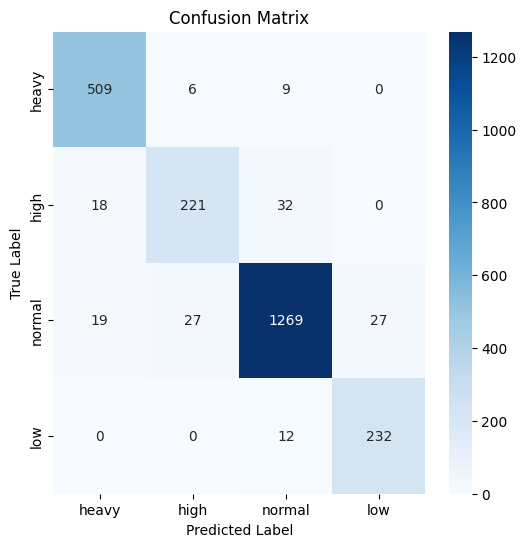

In [6]:
model = TrafficNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr) 

epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train) 
    loss = criterion(outputs, y_train) 
    loss.backward() 
    optimizer.step() 

model.eval()

with torch.no_grad():
    outputs = model(X_test)  # Forward pass
    predictions = torch.argmax(outputs, dim=1)  

# Compute accuracy
accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
print(f"Model Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_test.numpy(), predictions.numpy())

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()